In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import gaussian_kde

In [43]:
class KMeans():
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        random_state = check_random_state(self.random_state)
        n_samples, n_features = X.shape

        # Initialize cluster centers randomly
        self.cluster_centers_ = X[random_state.choice(n_samples, self.n_clusters, replace=False)]

        for i in range(self.max_iter):
            # Assign labels based on closest center
            labels = self._assign_labels(X)

            # Compute new centers as the mean of the points in each cluster
            new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

            # Check for convergence
            if np.linalg.norm(new_centers - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centers

        self.labels_ = labels
        return self.labels_

    def _assign_labels(self, X):
        # Calculate distances from points to cluster centers
        distances = euclidean_distances(X, self.cluster_centers_)
        # Assign each point to the nearest cluster center
        return np.argmin(distances, axis=1)


    def split_clusters(self, X, is_recursive=False, split_clusters = None):
        if is_recursive:
            unique_clusters = split_clusters
        else:
            # For initial call, process all clusters
            unique_clusters = np.unique(self.labels_)

        for i in unique_clusters:
            # Get data points belonging to the current cluster
            cluster_data = X[self.labels_ == i]
            filtered_cluster_data = self.remove_edge_points(cluster_data, i)
            density_matrix = self.get_density_matrix(filtered_cluster_data)

            if self.is_chain_connected(density_matrix):
                # Run K-Means to split the cluster into two
                kmeans_split = KMeans(n_clusters=2, random_state=self.random_state)
                split_labels = kmeans_split.fit(cluster_data)

                # Assign new cluster numbers
                max_label = self.labels_.max() + 1  # New cluster number
                for idx, point in enumerate(cluster_data):
                    original_index = np.where((X == point).all(axis=1))[0][0]
                    if split_labels[idx] == 1:
                        self.labels_[original_index] = max_label  # Assign new cluster label

                # Update the cluster centers
                self.cluster_centers_[i] = kmeans_split.cluster_centers_[0]  # Update existing cluster center
                self.cluster_centers_ = np.vstack([
                    self.cluster_centers_,
                    kmeans_split.cluster_centers_[1]  # Add new cluster center
                ])

                # Increment cluster count
                self.n_clusters += 1
                self.labels_ = self.split_clusters(X, is_recursive=True, split_clusters = [i, max_label])

        self.labels_ = self.reassignment(X)
        return self.labels_


    def remove_edge_points(self, cluster_data, i):
        distances = euclidean_distances(cluster_data, self.cluster_centers_[i].reshape(1, -1)).flatten()
        threshold = distances.mean() + 1.5 * distances.std()
        filtered_cluster_data = cluster_data[distances <= threshold]
        return filtered_cluster_data

    def is_chain_connected(self, matrix):
        rows, cols = len(matrix), len(matrix[0])

        def trim_edges(matrix):
            """Trims 15% of rows and columns from all sides of the matrix."""
            start_row, end_row = round(rows * 0.15), round(rows * 0.85)
            start_col, end_col = round(cols * 0.15), round(cols * 0.85)
            trimmed = [row[start_col:end_col] for row in matrix[start_row:end_row]]
            return trimmed

        def bfs(matrix, start_row, start_col, target_row=None, target_col=None):
            """Breadth-first search to find a valid path to the target."""
            queue = [(start_row, start_col)]
            visited = set(queue)
            rows, cols = len(matrix), len(matrix[0])

            while queue:
                x, y = queue.pop(0)

                # Check if we've reached the target
                if (target_row is not None and x == target_row) or (target_col is not None and y == target_col):
                    return True

                # Explore neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols and matrix[nx][ny] == 0 and (nx, ny) not in visited:
                        visited.add((nx, ny))
                        queue.append((nx, ny))

            return False

        # Trim the matrix
        trimmed_matrix = trim_edges(matrix)

        # Check for a top-to-bottom chain
        for col in range(len(trimmed_matrix[0])):
            if trimmed_matrix[0][col] == 0:
                if bfs(trimmed_matrix, 0, col, target_row=len(trimmed_matrix) - 1):
                    # print("Top to bottom chain found")
                    return True

        # Check for a left-to-right chain
        for row in range(len(trimmed_matrix)):
            if trimmed_matrix[row][0] == 0:
                if bfs(trimmed_matrix, row, 0, target_col=len(trimmed_matrix[0]) - 1):
                    # print("Left to right chain found")
                    return True

        return False
    
    def get_density_matrix(self, data, grid_resolution=10, threshold_percentile=25):
        if data.shape[0]<70:
            return np.ones((grid_resolution,grid_resolution))
        
        np.set_printoptions(suppress=True, precision=2)
        
        # Estimate KDE
        kde = gaussian_kde(data.T)

        # Define grid
        x_min, y_min = np.min(data, axis=0)
        x_max, y_max = np.max(data, axis=0)

        x_grid = np.linspace(x_min, x_max, grid_resolution)
        y_grid = np.linspace(y_min, y_max, grid_resolution)
        xx, yy = np.meshgrid(x_grid, y_grid)

        grid_coords = np.vstack([xx.ravel(), yy.ravel()])

        # Evaluate KDE on grid
        density_values = kde(grid_coords)
        density_matrix = density_values.reshape(grid_resolution, grid_resolution)
        
        # Normalize to [0, 1]
        density_matrix = (density_matrix - density_matrix.min()) / (density_matrix.max() - density_matrix.min())

        # Thresholding
        threshold = threshold_percentile / 100
        # print(density_matrix)
        density_matrix = (density_matrix >= threshold).astype(int)
        # print(density_matrix)
        
        return density_matrix


    def reassignment(self,X):
        for i in range(self.max_iter):
            # Assign labels based on closest center
            labels = self._assign_labels(X)

            # Compute new centers as the mean of the points in each cluster
            new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

            # Check for convergence
            if np.linalg.norm(new_centers - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centers

        return labels

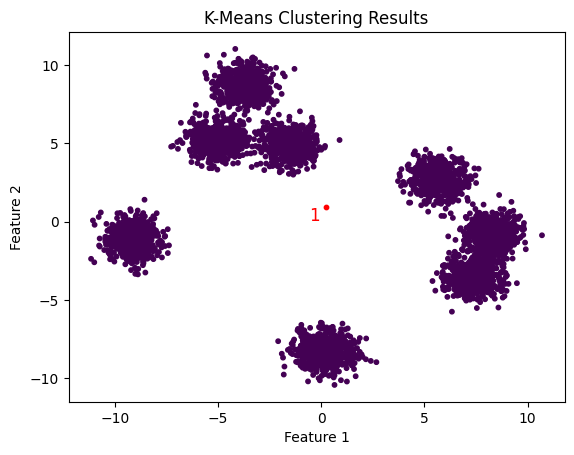

In [62]:
# Generate synthetic data with 8 clusters
# change n_samples, centers, random_state to get different dataset and
X, y = make_blobs(n_samples=4500, centers=8, cluster_std=0.7, random_state=46)
# Apply K-Means clustering with different num of clusters
kmeans = KMeans(n_clusters=1, random_state=50)
y_kmeans = kmeans.fit(X)
# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=10)
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.text(
        x - 0.6,  # Offset slightly to the left
        y - 0.6,  # Offset slightly downward
        str(i+1),
        color='red',
        fontsize=12,
        ha='center',
        va='center',
    )
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

[5 5 3 ... 3 5 5]


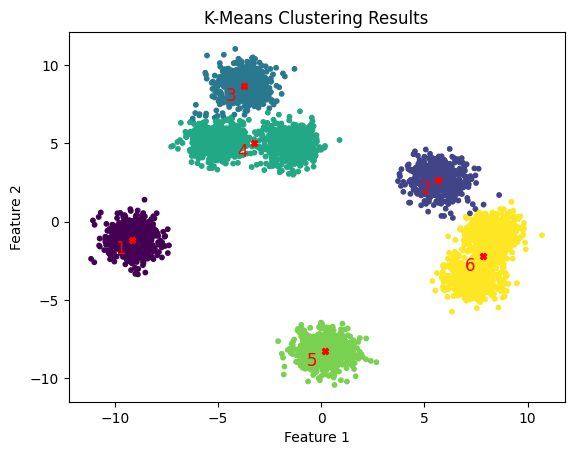

In [63]:
# calling the split_clusters function will split and give the final clustering result
y_kmeans = kmeans.split_clusters(X)
print(y_kmeans)
# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=20, marker='X')  # Mark the cluster centers
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.text(
        x - 0.6,  # Offset slightly to the left
        y - 0.6,  # Offset slightly downward
        str(i+1),
        color='red',
        fontsize=12,
        ha='center',
        va='center',
    )
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()